# Segmentation 

This notebook shows how to use Stardist (Object Detection with Star-convex Shapes) as a part of a segmentation-classification-tracking analysis pipeline. 

The sections of this notebook are as follows:

1. Load images
2. Load model of choice and segment an initial image to test Stardist parameters
3. Batch segment a sequence of images

The data used in this notebook is timelapse microscopy data with h2b-gfp/rfp markers that show the spatial extent of the nucleus and it's mitotic state. 

The dependencies of this notebook include the `daskoctopus.py` module from the CellX project that aids fast and efficient image loading. --- edit/clarify?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from octopuslite import DaskOctopusLiteLoader
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize
from tqdm import tqdm
from skimage.io import imsave

##### temp running on raw images to test speed

In [2]:
import json

In [ ]:
%%time
# load model
model = StarDist2D(None, name='stardist_multiclass_MDCK', basedir='models')
for expt, pos in zip(['MK0003'], ['Pos13', 'Pos14', 'Pos15', 'Pos12']):
    print('Starting experiment position:', expt, pos)
    # load images
    image_path = f'/home/nathan/data/kraken/commitment/{expt}/{pos}/{pos}_raw'
    images = DaskOctopusLiteLoader(image_path)
    # set output directory for segmented images
    if not os.path.exists(image_path.replace('_raw', '_stardist_masks')):
        os.mkdir(image_path.replace('_raw', '_stardist_masks'))
    for frame in tqdm(range(len(images['gfp']))):
#         # check if fn already exists
#         fn = (images.files('gfp')[frame].replace('_raw', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')
# #         if not os.path.isfile(fn):
        # compile 2-channels into XYC array
        img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
        img[:,:,0] = images['gfp'][frame]
        img[:,:,1] = images['rfp'][frame]
        # predict labels using 2ch image
        labels, details = model.predict_instances(normalize(img))
        # save out labelled image
        fn = (images.files('gfp')[frame].replace('_raw', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')
        imsave(fn, labels, check_contrast=False)
        # save out details array ## need to work on this to finesse
        fn = fn.replace('.tif', '_details.npz')
        np.savez(fn, details)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.552369, nms_thresh=0.3.
Starting experiment position: MK0003 Pos13
Using cropping: None


  3%|▎         | 31/1200 [00:35<21:07,  1.08s/it]

# iteration fails when there is an if clause to determine if seg file already exists???

In [16]:
fn

'/home/nathan/data/kraken/commitment/MK0003/Pos13/Pos13_stardist_masks/img_channel001_position013_time000000000_z000_stardist_masks_details.json'

In [18]:
fn = fn.replace('.json', '_details.npz')
np.savez(fn, details)

In [28]:
details_load = np.load(fn, allow_pickle= True)

In [29]:
for k in details_load.files:
    print(k)

arr_0


In [30]:
details_load['arr_0']

array({'coord': array([[[1102.        , 1106.18637691, 1110.30549936, ...,
         1090.20122066, 1093.7567467 , 1097.77832444],
        [ 341.60400963,  341.04633799,  340.0512492 , ...,
          337.65812116,  339.90097392,  341.22379628]],

       [[ 324.        ,  327.84943374,  332.14712187, ...,
          315.0681855 ,  317.64688482,  320.61323673],
        [  66.74094009,   67.35241027,   67.66889212, ...,
           61.36740505,   63.33777684,   65.02640875]],

       [[ 808.        ,  812.36335985,  817.31019592, ...,
          798.195951  ,  801.13742465,  804.3701318 ],
        [ 912.72587967,  913.93609129,  914.47680126, ...,
          906.67279623,  908.56772248,  910.24857973]],

       ...,

       [[ 478.        ,  478.91129229,  479.81413087, ...,
          474.88482823,  475.87905225,  476.99254892],
        [ 325.06711388,  324.58137572,  324.37969936, ...,
          324.66218402,  325.12042082,  325.06479861]],

       [[1084.        , 1085.68276305, 1087.1686628

In [10]:
type(details)

dict

## 1. Load images

Timelapse microscopy experiments conducted under the CellX project have the following generic data structure:

`Nathan\ND0000\Pos0\Pos0_aligned`

In [2]:
# define experiment ID and select a position
expt = 'MK0003'
pos = 'Pos1'
image_path = f'/home/nathan/data/kraken/commitment/test/{expt}/{pos}/{pos}_aligned'
images = DaskOctopusLiteLoader(image_path)

Using cropping: None


## 2. Load model and test segment single image 

In [2]:
model = StarDist2D(None, name='stardist_multiclass_MDCK', basedir='models')
model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.552369, nms_thresh=0.3.


StarDist2D(stardist_multiclass_MDCK): YXC → YXC
├─ Directory: /home/nathan/analysis/cell-comp-analysis/segment-classify-track/models/stardist_multiclass_MDCK
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=2, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=2, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 2], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2, 1], train_class_weights=[1, 1, 1], train_epochs=400, train_steps_per_epoch=100,

In [31]:
 "cellx_classifier_stardist.h5"))# set test image index
frame = 100
# load test image 
gfp = images['gfp'][frame]
rfp = images['rfp'][frame]
# create 2-channel image
img = np.zeros((gfp.shape[0], gfp.shape[1] ,2), dtype = 'uint8') 
img[:,:,0] = gfp
img[:,:,1] = rfp
img.shape

(1352, 1688, 2)

### 2.1 Test run and display initial results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


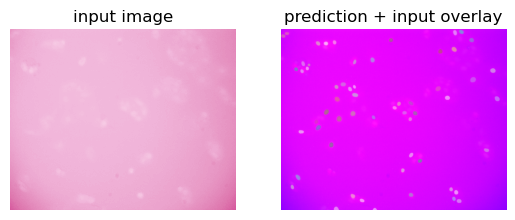

In [32]:
# initialise test segmentation
labels, details = model.predict_instances(normalize(img))

# plot input image and prediction
plt.clf()
plt.subplot(1,2,1)
plt.imshow(normalize(img[:,:,0]), cmap="PiYG")
plt.axis("off")
plt.title("input image")
plt.subplot(1,2,2)
plt.imshow(render_label(labels, img = img))
plt.axis("off")
plt.title("prediction + input overlay")
plt.show()

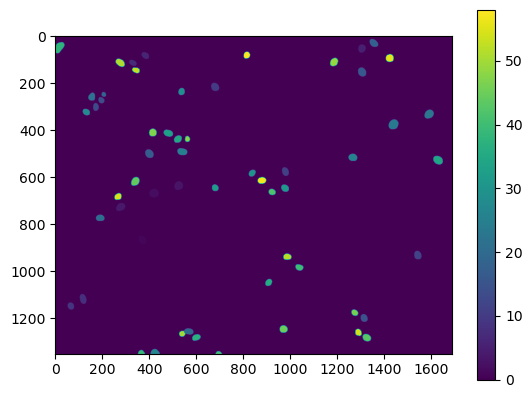

In [102]:
plt.imshow(labels)
plt.colorbar()
plt.show()

## 3. Batch segment a whole stack of images

In [ ]:
%%time
for expt, pos in zip(['MK0003', 'MK0001'], ['Pos1', 'Pos0']):
    print('Starting experiment position:', expt, pos)
    # load images
    image_path = f'/home/nathan/data/kraken/commitment/test/{expt}/{pos}/{pos}_aligned'
    images = DaskOctopusLiteLoader(image_path)
    # set output directory for segmented images
    if not os.path.exists(image_path.replace('aligned', 'stardist_masks')):
        os.mkdir(image_path.replace('_aligned', '_stardist_masks'))
    for frame in tqdm(range(len(images['gfp']))):
        # compile 2-channels into XYC array
        img = np.zeros((images['gfp'][frame].shape[0], images['gfp'][frame].shape[1], 2)) 
        img[:,:,0] = images['gfp'][frame]
        img[:,:,1] = images['rfp'][frame]
        # predict labels using 2ch image
        labels, _ = model.predict_instances(normalize(img))
        # save out labelled image
        fn = (images.files('gfp')[frame].replace('_aligned', '_stardist_masks')).replace('.tif', '_stardist_masks.tif')
        imsave(fn, labels, check_contrast=False)

Starting experiment position: MK0003 Pos12
Using cropping: None


  0%|          | 0/1200 [00:00<?, ?it/s]